Problem:
Once we sequenced a cancer tumor, we can identify thousands of mutations. The challenge is to distinguish the mutations that contribute to turmor growth, we call drivers, from the neutral mutations that we can passengers. Provided with an expert-annotated knowledge base, can you develop a ML algorithm that automatically classifies genetic variants?
The knowledge base for each annotated variant is a collection of relevant journal articles, done by experts. The assumption is that the text contains enough information for classification. 

Traingin Data:
    The name of the genes, and the corresponding variant type are categorized into 9 classes, based on a large body of journal texts. The meanings of the 9 classes are unknown during the competition. I listed below because it helps to understand the classification.
    External knowledge about the 9 classes:
    7:gain of function, 2:likely gof, 3:neutral, 5:likely neutral, 6:inconclusive, 1:likely loss of func., 4:lof, 8:likely swithc off func, 9: sof

Use pandas, numpy, xgboost, sklearn, matplotlib.

Hightlights:
* Feature analysis:  
  Use regular expression for text search and counting occurences of gene/variant in the text.
* Feature engineering:  
  Use the wild-type/mutant residue information improve the prediction significantly. e.g., a mutation of Val-Arg may unstabilize the protein and cause loss of function.  
  Use label_Encoder for dummy variables.
* Modeling:  
  Use Pipleline.FeatureUnion to combine several feature extraction into a big transformer.  
  Using xgboost combined with model stacking improves accuracy significantly.  
  Use TfidfVectorizer with 2 or 3-gram (4-gram is pushing my 24GB memory limit) for NLP.  
  Use Truncated SVD for further dimensionality reduction on Tfidf matricies. 
  Due to the time constraint, I didn't get to try other NLP techniques such as lemmatization and LDA. Maybe next time.  

* Acknowledgement: Thanks 1owl for his insightful kernel. My kernel is based on his framework.

In [2]:
import pandas  as pd
import numpy   as np
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

##Load data
train_var  = pd.read_csv('input/train_variants_stage2.csv')
test_var   = pd.read_csv('input/stage2/stage2_test_variants.csv')

trainx     = pd.read_csv('input/train_text_stage2.csv', header=None, names=["Text"])
testx      = pd.read_csv('input/stage2/stage2_test_text.csv',     sep="\|\|", 
                         engine='python', header=None, skiprows=1, names=["ID","Text"])
print("Done loading!")
train_var.head()

/Users/wz12/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Done loading!


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
print(train_var.shape, trainx.shape, test_var.shape, testx.shape)
trainx['ID'] = trainx.index
trainx.head()

#Put data and text together
train = pd.merge(train_var, trainx, how='left', on='ID').fillna('')
test  = pd.merge(test_var,  testx,  how='left', on='ID').fillna('')
print(train.shape, test.shape)

(3689, 4) (3689, 1) (986, 3) (986, 2)
(3689, 5) (986, 4)


In [4]:
import numpy as np
#seperate training data from values
y     = train['Class'].values - 1
train = train.drop(['Class'], axis=1)
pid   = test['ID'].values
print(train.shape, test.shape)
print(np.unique(y))

(3689, 4) (986, 4)
[0 1 2 3 4 5 6 7 8]


(4675, 4)
sum: 3832
sum: 3068
CPU times: user 1min 17s, sys: 346 ms, total: 1min 18s
Wall time: 1min 18s


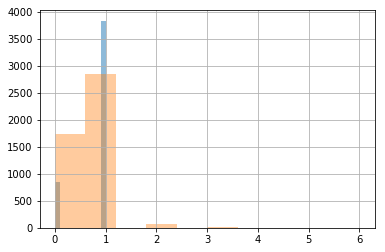

In [5]:
%%time
##########################
####Feature Engineering 1
##########################
%matplotlib inline
import re
df_all= pd.concat((train, test), axis=0, ignore_index=True)
print(df_all.shape)
import matplotlib.pyplot as plt

#delimiters = [" ", "(", ")", "/", ".", ","]
#regex = '|'.join(map(re.escape, delimiters))
regex = ' |\)|\.\(|\/|-|\[|\]||{|\}'
#print("regex:", regex)
df_all['Gene_Share'] = df_all.apply(
    lambda r:sum([1 for w in r['Gene'].split(' ') \
                  if w.lower() in re.split(regex, r.Text.lower()) ]), axis=1)
df_all['Variation_Share'] = df_all.apply(
    lambda r:sum([1 for w in r['Variation'].split(' ') \
                  if w.lower() in re.split(regex, r.Text.lower()) ]), axis=1)
print("sum:", sum(df_all['Gene_Share']))
print("sum:", sum(df_all['Variation_Share']))
df_all['Gene_Share'].hist(alpha=0.5) #check whether the gene name is mentioned in the text, split by ' '
df_all['Variation_Share'].hist(alpha=0.4) #Variants may contain up to 5 words separated by space

Gene found in corresponding training text,     sum:3371, ratio:91.4%
Varaints found in corresponding training text, sum:2347, ratio:63.6%


,ID,Gene,Variation,Text,Gene_Share,Variation_Share
3646,3646,RUNX1,S291fsX300,Introduction Myelodysplastic syndromes (MDS) ...,0,1
3674,3674,CCND3,D286_L292trunc,The activities of cyclin D-dependent kinases s...,0,0
3681,3681,NFE2L2,D29N,The Nrf2 (nuclear factor erythroid 2 [NF-E2]-r...,0,0
3683,3683,MAP2K1,L115P,Genetic alterations that activate the mitogen-...,0,1
3686,3686,MAP2K1,H119P,Genetic alterations that activate the mitogen-...,0,0


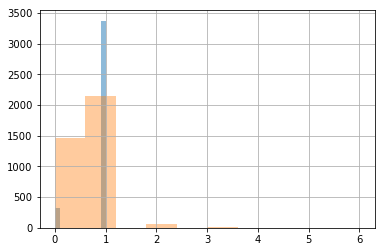

In [6]:
#investigate why some genes/variants are not found in texts
tmp = df_all.loc[range(len(train))]
print("Gene found in corresponding training text,     sum:{}, ratio:{}%".format(sum(tmp.Gene_Share), 
                            round(100*sum(tmp.Gene_Share)/len(tmp),1)))
print("Varaints found in corresponding training text, sum:{}, ratio:{}%".format(sum(tmp.Variation_Share), 
                            round(100*sum(tmp.Variation_Share)/len(tmp),1)))

tmp.Gene_Share.hist(alpha=0.5) #check whether the gene name is mentioned in the text, split by ' '
tmp.Variation_Share.hist(alpha=0.4) #Variants may contain up to 5 words separated by space
gene_not_share = tmp.loc[tmp.Gene_Share == 0]
vari_not_share = tmp.loc[tmp.Variation_Share == 0]
gene_not_share.tail()

In [7]:
len(gene_not_share)

318

In [8]:
df_all.loc[df_all['Variation_Share']>=3, 'Variation']

188                                      Exon 19 deletion
197                                     Exon 20 insertion
198                                     Exon 19 insertion
412                          DNA binding domain deletions
428                         DNA binding domain insertions
480                 DNA binding domain missense mutations
631                                      Copy Number Loss
743                                    Exon 20 insertions
1410                              FGFR3 - BAIAP2L1 Fusion
1640                    FLT3 internal tandem duplications
3008                                    Exon 11 mutations
3025                                     Exon 9 mutations
3060                                     Exon 1 mutations
3062                                     Exon 2 mutations
3073              Truncating Mutations in the PEST Domain
3078    Truncating Mutations Upstream of Transactivati...
3221                               TRKAIII Splice Variant
3389          

9 55


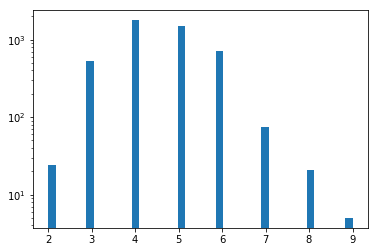

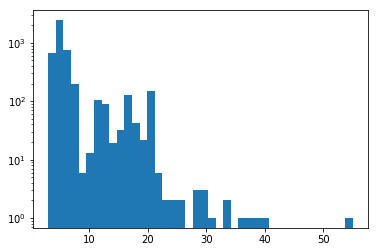

In [9]:
gene_len = [len(x) for x in df_all.Gene ]
vari_len = [len(x) for x in df_all.Variation ]
print(max(gene_len), max(vari_len))
plt.figure()
_=plt.hist(gene_len, log=True, bins=40)
plt.figure()
_=plt.hist(vari_len, log=True, bins=40)

In [10]:
#commented for Kaggle Limits
#Feature engineering 3
#############################

# for i in range(max(gene_len)):
#     df_all['Gene_'+str(i)] = df_all['Gene'].map( 
#         lambda x: str(x[i]) if len(x)>i else '')
for i in range(23):
    df_all['Variation_'+str(i)] = df_all['Variation'].map(
        lambda x: str(x[i]) if len(x)>i else '')
    
print(df_all.shape)

##Add one more feature, a very effective one: the wildtype and mutant residues.
df_all['var_wild_plus_mut'] = pd.Series(
    map(lambda x: x[0]+x[-1], df_all['Variation']))
df_all.head()

(4675, 29)


,ID,Gene,Variation,Text,Gene_Share,Variation_Share,Variation_0,Variation_1,Variation_2,Variation_3,...,Variation_14,Variation_15,Variation_16,Variation_17,Variation_18,Variation_19,Variation_20,Variation_21,Variation_22,var_wild_plus_mut
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...,1,1,T,r,u,n,...,a,t,i,o,n,s,,,,Ts
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...,1,1,W,8,0,2,...,,,,,,,,,,W*
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...,1,1,Q,2,4,9,...,,,,,,,,,,QE
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...,1,1,N,4,5,4,...,,,,,,,,,,ND
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...,1,1,L,3,9,9,...,,,,,,,,,,LV


In [11]:
#combine training genes and variants into a big list
#used for text Search and Match later
gen_var_lst = sorted(list(train.Gene.unique()) + list(train.Variation.unique()))
print(len(gen_var_lst))

#Using the first word for simplicity
gen_var_lst = [ x.split(' ')[0] for x in gen_var_lst] 
print(len(gen_var_lst))

3578
3578


In [12]:
#Feature engineering 3
############################

#count occurencies in the text
i_ = 0
for gen_var_lst_itm in gen_var_lst:
    if i_ % 100 == 0: print(i_)
    df_all['GV_'+str(gen_var_lst_itm)] = df_all['Text'].map(
        lambda x: str(x).lower().count(str(gen_var_lst_itm).lower()))
    i_ += 1
    
print(df_all.shape)
#(4675, 3613)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
(4675, 3590)


In [13]:
print(df_all.shape, y.shape)
df_all_backup = df_all.copy()
df_all_backup.shape

(4675, 3590) (3689,)


(4675, 3590)

In [40]:
df_all.columns

Index(['ID', 'Gene', 'Variation', 'Text', 'Gene_Share', 'Variation_Share',
       'Variation_0', 'Variation_1', 'Variation_2', 'Variation_3',
       ...
       'GV_Y98H', 'GV_Y98N', 'GV_YAP1', 'GV_YAP1-FAM118B', 'GV_YAP1-MAMLD1',
       'GV_YAP1-TFE3', 'GV_YWHAE-ROS1', 'GV_ZC3H7B-BCOR', 'GV_ZNF198-FGFR1',
       'GV_p61BRAF'],
      dtype='object', length=3590)

In [17]:
from sklearn import preprocessing
from sklearn import base
from sklearn import pipeline
from sklearn import feature_extraction
from sklearn import decomposition
from sklearn import model_selection
from sklearn import metrics

#Adding new features to df_all
for c in df_all.columns:
    if df_all[c].dtype == 'object':
        if c in ['Gene','Variation']: 
            lbl = preprocessing.LabelEncoder()
            df_all[c+'_lbl_enc'] = lbl.fit_transform(df_all[c].values)  
            df_all[c+'_len']     = df_all[c].map(lambda x: len(str(x)))
            df_all[c+'_words']   = df_all[c].map(lambda x: len(str(x).split(' ')))
        elif c != 'Text':  #including 'var_wild_plus_mut'
            lbl = preprocessing.LabelEncoder()
            df_all[c] = lbl.fit_transform(df_all[c].values)
        if c=='Text': 
            df_all[c+'_len']   = df_all[c].map(lambda x: len(str(x)))
            df_all[c+'_words'] = df_all[c].map(lambda x: len(str(x).split(' '))) 

train = df_all.iloc[:len(train_var)] #iloc takes only integer indices
test  = df_all.iloc[len(train_var):]
print(train.shape, test.shape)

class cust_regression_vals(base.BaseEstimator, base.TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x = x.drop(['Gene', 'Variation', 'ID','Text'],axis=1).values
        return x

class cust_txt_col(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        return x[self.key].apply(str)

#Convert data to a representation suitable for training
print('Pipeline...')
fp = pipeline.Pipeline([(
    'union', pipeline.FeatureUnion(
        n_jobs = -1,
        transformer_list = [
            (
                'standard', 
                cust_regression_vals()
            ),
            (
                'pi1', 
                pipeline.Pipeline([
                    ('Gene', cust_txt_col('Gene')),
                    ('count_Gene', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1,8))),
                    ('tsvd1', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=12))
                ])
            ),
            (
                'pi2', pipeline.Pipeline([
                    ('Variation', cust_txt_col('Variation')), 
                    ('count_Variation',feature_extraction.text.CountVectorizer(analyzer=u'char',ngram_range=(1,8))), 
                    ('tsvd2', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=12))
                ])
            ),
            #commented for Kaggle Limits
            ('pi3', pipeline.Pipeline(
                [
                    ('Text', cust_txt_col('Text')), 
                    ('tfidf_Text', feature_extraction.text.TfidfVectorizer(ngram_range=(1, 2))), 
                    ('tsvd3', decomposition.TruncatedSVD(n_components=50, n_iter=25, random_state=12))])
            )
        ]
    )
)])

#Put pipeline in use right here!
train = fp.fit_transform(train)
test  = fp.transform(test);      
print(train.shape, test.shape)
# (3652, 3621) (986, 3621)
# (3652, 3707) (986, 3707)

(3689, 3598) (986, 3598)
Pipeline...
(3689, 3684) (986, 3684)


In [18]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [19]:
%%time
#######################
####Run for production
#######################

#not for run,
#keep for record
names = ['ID','class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9']
denom = 0
fold = 10 #Change to 5, 1 for Kaggle Limits
for i in range(fold):
    params = {
        'eta': 0.05,
        'max_depth': 6,
        'min_child_weight':3,
        'objective': 'multi:softprob', #multinomial logistics regression
        'eval_metric': 'mlogloss',
        'num_class': 9,
        'seed': i,
        'silent': True
    }
    x1, x2, y1, y2 = model_selection.train_test_split(train, y, test_size=0.18, random_state=i)
    
    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
    
    model = xgb.train(params, xgb.DMatrix(x1, y1), 1000,  watchlist, verbose_eval=100, early_stopping_rounds=100)
    score1 = metrics.log_loss(y2, model.predict(xgb.DMatrix(x2), ntree_limit=model.best_ntree_limit), 
                              labels=list(range(9)))
    print(i, score1)
    #if score < 0.9:
    if denom != 0:
        pred   = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        preds += pred

        train_pred   = model.predict(xgb.DMatrix(train), ntree_limit=model.best_ntree_limit+80)
        train_preds += train_pred

    else:
        pred   = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        preds  = pred.copy()
        
        train_pred   = model.predict(xgb.DMatrix(train), ntree_limit=model.best_ntree_limit+80)        
        train_preds  = train_pred.copy()
        
    denom += 1
    submission = pd.DataFrame(pred, columns=['class'+str(c+1) for c in range(9)])
    submission['ID'] = pid
    #submission.to_csv('submission_stage2_10fold'  + str(i) + '.csv', index=False)
preds       /= denom
train_preds /= denom

submission = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = pid
submission=submission[names]
submission.to_csv('output/submission_stage2_all_no_gene_name_final.csv', index=False)

[0]	train-mlogloss:2.10012	valid-mlogloss:2.11597
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[100]	train-mlogloss:0.459925	valid-mlogloss:0.930422
[200]	train-mlogloss:0.224214	valid-mlogloss:0.891717
[300]	train-mlogloss:0.119677	valid-mlogloss:0.903867
Stopping. Best iteration:
[212]	train-mlogloss:0.207811	valid-mlogloss:0.891003

10 0.89100330523
[0]	train-mlogloss:2.10077	valid-mlogloss:2.11079
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[100]	train-mlogloss:0.466626	valid-mlogloss:0.867544
[200]	train-mlogloss:0.229284	valid-mlogloss:0.823113
Stopping. Best iteration:
[195]	train-mlogloss:0.236766	valid-mlogloss:0.822128

10 0.822127930029
[0]	train-mlogloss:2.10069	valid-mlogloss:2.11148
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for e